# 1. Preprocess one image
In this notebook we will preprocess geoTIFFs and manually labeled data geoJSON files into training and validation data for deep learning. In this section we will preprocess one image and its corresponding label file. In the next section we will use the same pipeline to preprocess all images and labels and build training and validation datasets.

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import geopandas as gpd
import rasterio
import solaris as sol

c:\Users\HarrisonK\AppData\Local\miniforge3\envs\geo\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\HarrisonK\AppData\Local\miniforge3\envs\geo\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\HarrisonK\AppData\Local\miniforge3\envs\geo\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\HarrisonK\App

## Define constants and generate file paths
We'll be using slippy map tiles of `tile_size = 256` and `zoom = 19` which is a good balance between image resolution and processing time for the number of tiles.

In [27]:
TILE_SIZE = 256
ZOOM_LEVEL = 19

# First create a data directory and subdirectories for images and masks
DATA_DIR = Path('./data')
DATA_DIR.mkdir(exist_ok=True)

# Create subdirectory for tile size (s) and zoom level (z)
IMAGE_PATH = DATA_DIR / 'images'
IMAGE_PATH.mkdir(exist_ok=True)

MASKS_PATH = DATA_DIR / 'masks'
MASKS_PATH.mkdir(exist_ok=True)

# Create tile size (s) and zoom level (z) subdirectories within images and masks
(IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}').mkdir(exist_ok=True)
(MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}').mkdir(exist_ok=True)

# Create training and validation subdirectories within images and masks
(IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'train').mkdir(exist_ok=True)
(IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'validation').mkdir(exist_ok=True)

(MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'train').mkdir(exist_ok=True)
(MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'validation').mkdir(exist_ok=True)

# Define path to raw inputs
LABELS_INPUT_PATH = DATA_DIR / 'raw-inputs' / 'znz001_labels.geojson'
TIF_INPUT_PATH = DATA_DIR / 'raw-inputs' / 'znz001_image.tif'

We'll get data from the Tanzania Open AI Challenge dataset of 7-cm resolution drone imagery and manually labeled building footprints. We'll create training and validation datasets from a single drone image (cloud-optimised geoTIFF) and its corresponding geoJSON file of building footprints.

,pk_0,pk,pkuid,building,unfinished,problemati,changeset,area,condition,geometry
0,1,None,None,None,None,None,None,None,Complete,"POLYGON ((39.30436 -5.72267, 39.30438 -5.72264..."
1,2,None,None,None,None,None,None,None,Complete,"POLYGON ((39.29424 -5.72488, 39.29428 -5.72481..."
2,3,None,None,None,None,None,None,None,Complete,"POLYGON ((39.29415 -5.72492, 39.29423 -5.72488..."
3,4,None,None,None,None,None,None,None,Complete,"POLYGON ((39.29405 -5.72494, 39.29414 -5.72493..."
4,5,None,None,None,None,None,None,None,Complete,"POLYGON ((39.29397 -5.72490, 39.29405 -5.72494..."


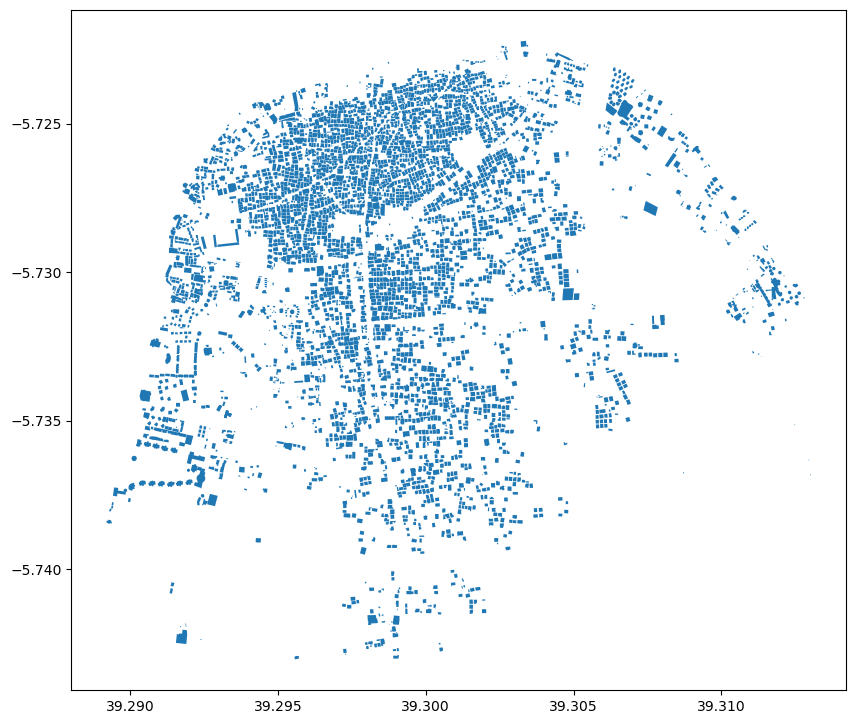

In [3]:
# Load the building footprints into a GeoDataFrame and remove null geometries
labels_gdf = gpd.read_file(LABELS_INPUT_PATH)
labels_gdf = labels_gdf[labels_gdf['geometry'].notnull()]

# Visualize the GeoDataFrame
labels_gdf.plot(figsize=(10, 10))
labels_gdf.head()

## We'll use geojson.io to draw train and validation areas
As we are using a single image, we'll draw polygons for training and validation data. Using geojson.io we will draw `train` and `validation` polygons in geoJSON format and add `dataset: train` and `dataset: validation` properties to each polygon. We'll save the geoJSON file as `train.geojson` and `validation.geojson` respectively.

Here is the [GeoJSON file](https://geojson.io/#id=gist:daveluo/8e192744b2aa377db162bc34e0e0ae64&map=13.3/-5.73423/39.29834) file that I created in geojson.io.

## Generate slippy map tile polygons using supermercado and geopandas

Next we'll use [`supermercado`](https://github.com/mapbox/supermercado) to generate square polygons representing each slippy map tile that we'll create from the tiff image. We'll specify a zoom level and make use of the geoJSON `training` and `validation` polygons to assign the resulting tiles to either the training or validation dataset.

Then we will merge the supermercado tile polygons into one GeoDataFrame using `geopandas`.

<AxesSubplot:>

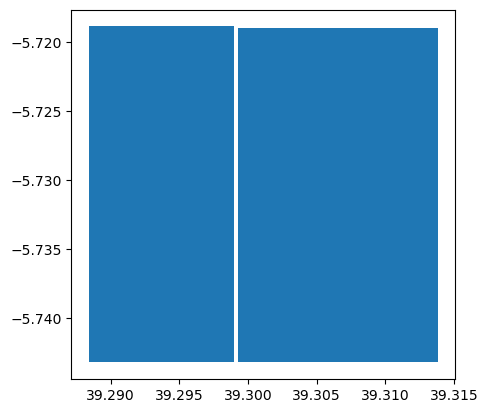

In [4]:
# Import the geojson.io train/test polygons file
train_val_areas_gdf = gpd.read_file('./data/raw-inputs/train_test_polygons.geojson')

# Plot the train/test polygons
train_val_areas_gdf.plot()

In [5]:
# Create two geoJSON files for the train and test polygons
train_areas_gdf = train_val_areas_gdf[train_val_areas_gdf['dataset'] == 'train']
train_areas_gdf.to_file('./data/polygons/train_area.geojson', driver='GeoJSON')

test_areas_gdf = train_val_areas_gdf[train_val_areas_gdf['dataset'] == 'validation']
test_areas_gdf.to_file('./data/polygons/validation_area.geojson', driver='GeoJSON')

Use `supermercado burn` to take the input geoJSON train and validation polygon files and return a stream of slippy map tile polygons at the specified zoom level. The usage is `<{geojson} stream> | supermercado burn <zoom> | fio collect > {output_filename.geojson}`. 

Run the following printed commands from a bash terminal to generate the building polygons for the training and validation datasets. If like me you are using Windows, you can use the [Windows Subsystem for Linux](https://docs.microsoft.com/en-us/windows/wsl/install-win10) to run bash commands.

In [6]:
command_train = f"cat data/polygons/train_area.geojson | supermercado burn {ZOOM_LEVEL}" + \
                f"| mercantile shapes | fio collect > data/polygons/train_z{ZOOM_LEVEL}tiles.geojson"

command_validation = f"cat data/polygons/validation_area.geojson | supermercado burn {ZOOM_LEVEL}" + \
                    f"| mercantile shapes | fio collect > data/polygons/validation_z{ZOOM_LEVEL}tiles.geojson"

print(command_train, '\n')
print(command_validation)

cat data/polygons/train_area.geojson | supermercado burn 19| mercantile shapes | fio collect > data/polygons/train_z19tiles.geojson 

cat data/polygons/validation_area.geojson | supermercado burn 19| mercantile shapes | fio collect > data/polygons/validation_z19tiles.geojson


In [7]:
# Read back in the train and validation tiles generated from the command line
train_tiles = gpd.read_file('./data/polygons/train_z19tiles.geojson')
validation_tiles = gpd.read_file('./data/polygons/validation_z19tiles.geojson')

# Add the train and validation labels to a new column called 'dataset'
train_tiles['dataset'] = 'train'
validation_tiles['dataset'] = 'validation'

train_tiles.head()

,id,title,geometry,dataset
0,"(319377, 270486, 19)","XYZ tile (319377, 270486, 19)","POLYGON ((39.29878 -5.71916, 39.29878 -5.71848...",train
1,"(319378, 270486, 19)","XYZ tile (319378, 270486, 19)","POLYGON ((39.29947 -5.71916, 39.29947 -5.71848...",train
2,"(319379, 270486, 19)","XYZ tile (319379, 270486, 19)","POLYGON ((39.30016 -5.71916, 39.30016 -5.71848...",train
3,"(319380, 270486, 19)","XYZ tile (319380, 270486, 19)","POLYGON ((39.30084 -5.71916, 39.30084 -5.71848...",train
4,"(319381, 270486, 19)","XYZ tile (319381, 270486, 19)","POLYGON ((39.30153 -5.71916, 39.30153 -5.71848...",train


<AxesSubplot:>

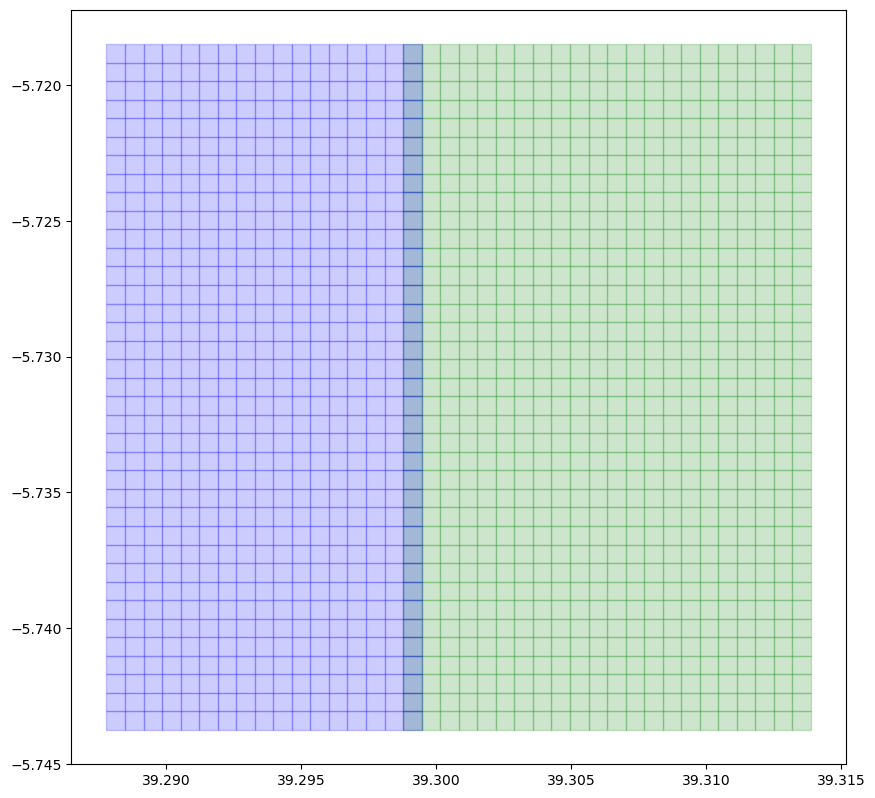

In [8]:
# Check overlapping tiles between training and validation
fig, ax = plt.subplots(figsize=(10, 10))
train_tiles.plot(ax=ax, color='green', alpha=0.2, edgecolor='green')
validation_tiles.plot(ax=ax, color='blue', alpha=0.2, edgecolor='blue')

id            object
title         object
geometry    geometry
dataset       object
dtype: object


,id,title,geometry,dataset
0,"(319377, 270486, 19)","XYZ tile (319377, 270486, 19)","POLYGON ((39.29878 -5.71916, 39.29878 -5.71848...",train
1,"(319378, 270486, 19)","XYZ tile (319378, 270486, 19)","POLYGON ((39.29947 -5.71916, 39.29947 -5.71848...",train
2,"(319379, 270486, 19)","XYZ tile (319379, 270486, 19)","POLYGON ((39.30016 -5.71916, 39.30016 -5.71848...",train
3,"(319380, 270486, 19)","XYZ tile (319380, 270486, 19)","POLYGON ((39.30084 -5.71916, 39.30084 -5.71848...",train
4,"(319381, 270486, 19)","XYZ tile (319381, 270486, 19)","POLYGON ((39.30153 -5.71916, 39.30153 -5.71848...",train


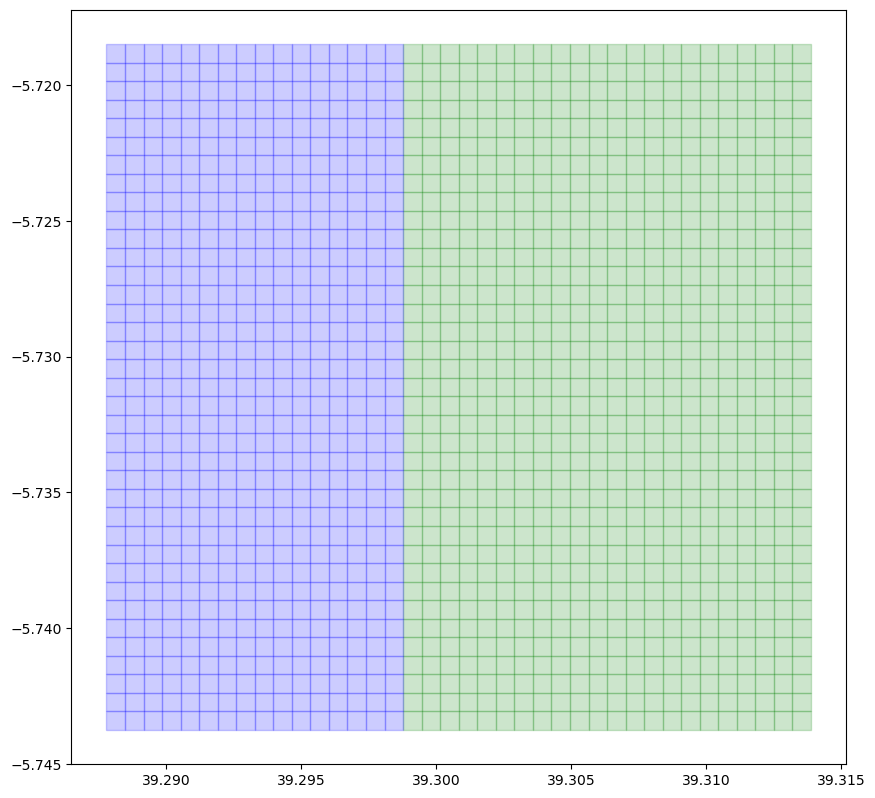

In [9]:
# Merge the train and validation tiles into a single GeoDataFrame dropping any duplicates
tiles_gdf = gpd.GeoDataFrame(pd.concat([train_tiles, validation_tiles], ignore_index=True), crs=train_tiles.crs)
tiles_gdf.drop_duplicates(subset=['id'], inplace=True)

# Plot the merged tiles
fig, ax = plt.subplots(figsize=(10, 10))
tiles_gdf[tiles_gdf['dataset'] == 'train'].plot(ax=ax, color='green',
                                                alpha=0.2, edgecolor='green')
tiles_gdf[tiles_gdf['dataset'] == 'validation'].plot(ax=ax, color='blue',
                                                     alpha=0.2, edgecolor='blue')

# Check the dataframe column types
print(tiles_gdf.dtypes)
tiles_gdf.head()

In [10]:
import ast

# Convert the id column from a string into a type of integers
tiles_gdf['id'] = tiles_gdf['id'].apply(lambda x: ast.literal_eval(x))

# Rename the id column to coordinates
tiles_gdf.rename(columns={'id': 'coordinates'}, inplace=True)

tiles_gdf.head()

,coordinates,title,geometry,dataset
0,"(319377, 270486, 19)","XYZ tile (319377, 270486, 19)","POLYGON ((39.29878 -5.71916, 39.29878 -5.71848...",train
1,"(319378, 270486, 19)","XYZ tile (319378, 270486, 19)","POLYGON ((39.29947 -5.71916, 39.29947 -5.71848...",train
2,"(319379, 270486, 19)","XYZ tile (319379, 270486, 19)","POLYGON ((39.30016 -5.71916, 39.30016 -5.71848...",train
3,"(319380, 270486, 19)","XYZ tile (319380, 270486, 19)","POLYGON ((39.30084 -5.71916, 39.30084 -5.71848...",train
4,"(319381, 270486, 19)","XYZ tile (319381, 270486, 19)","POLYGON ((39.30153 -5.71916, 39.30153 -5.71848...",train


## Create slippy map tile images using rio-tiler
We'll use [`rio-tiler`](https://github.com/cogeotiff/rio-tiler) and the slippy map tile polygons we generated using `supermercado` to create slippy map tile images for the training and validation datasets. We will also load the geoJSON labels file into a GeoDataFrame and crop the the building geometries to the tile boundaries using `geopandas`.

At first let's just look at one tile.

In [11]:
from rio_tiler import main as rt_main
from rasterio.transform import from_bounds
from shapely.geometry import Polygon as ShapelyPolygon
from shapely.ops import cascaded_union, unary_union

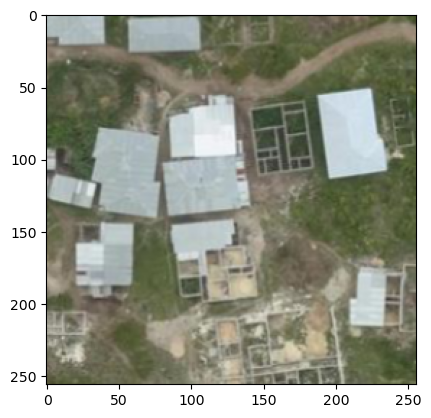

In [12]:
# Get an image for a single tile
id = 333
xyz = tiles_gdf.iloc[id]['coordinates']

tile, mask = rt_main.tile(TIF_INPUT_PATH, xyz[0], xyz[1], xyz[2], TILE_SIZE)

# Reshape the tile from (3, 256, 256) to (256, 256, 3) to plot
plt.imshow(np.moveaxis(tile, 0, -1))

In [13]:
# Merge all polygons that overlap each other into a single polygon
from shapely.geometry import MultiPolygon
from geopandas import GeoSeries

def clean_invalid_geometries(polygons: GeoSeries) -> GeoSeries:
    '''
    This function takes a list of Polygon geometries, merges all overlapping polygons into
    a single polygon,cleans any invalid geometries by buffering them by 0, and returns a
    GeoSeries of the cleaned geometries.

    If the merged geometry is a MultiPolygon (i.e., multiple disconnected polygons),
    it converts the MultiPolygon into a list of its component Polygon geometries.

    Args:
        polygons (GeoSeries): A GeoSeries of Polygon geometries to clean and merge.

    Returns:
        GeoSeries: A GeoSeries of the cleaned Polygon geometries.
    '''
    # Merge all polygons and clean invalid geometries
    merged_polygons = unary_union([p.buffer(0) for p in polygons])

    # If the merged geometry is a MultiPolygon, convert it to a list of Polygons
    if isinstance(merged_polygons, MultiPolygon):
        polygons = [p for p in merged_polygons.geoms]
    else:
        polygons = [merged_polygons]

    return gpd.GeoSeries(polygons)

Text(0.5, 1.0, 'Merged Polygons')

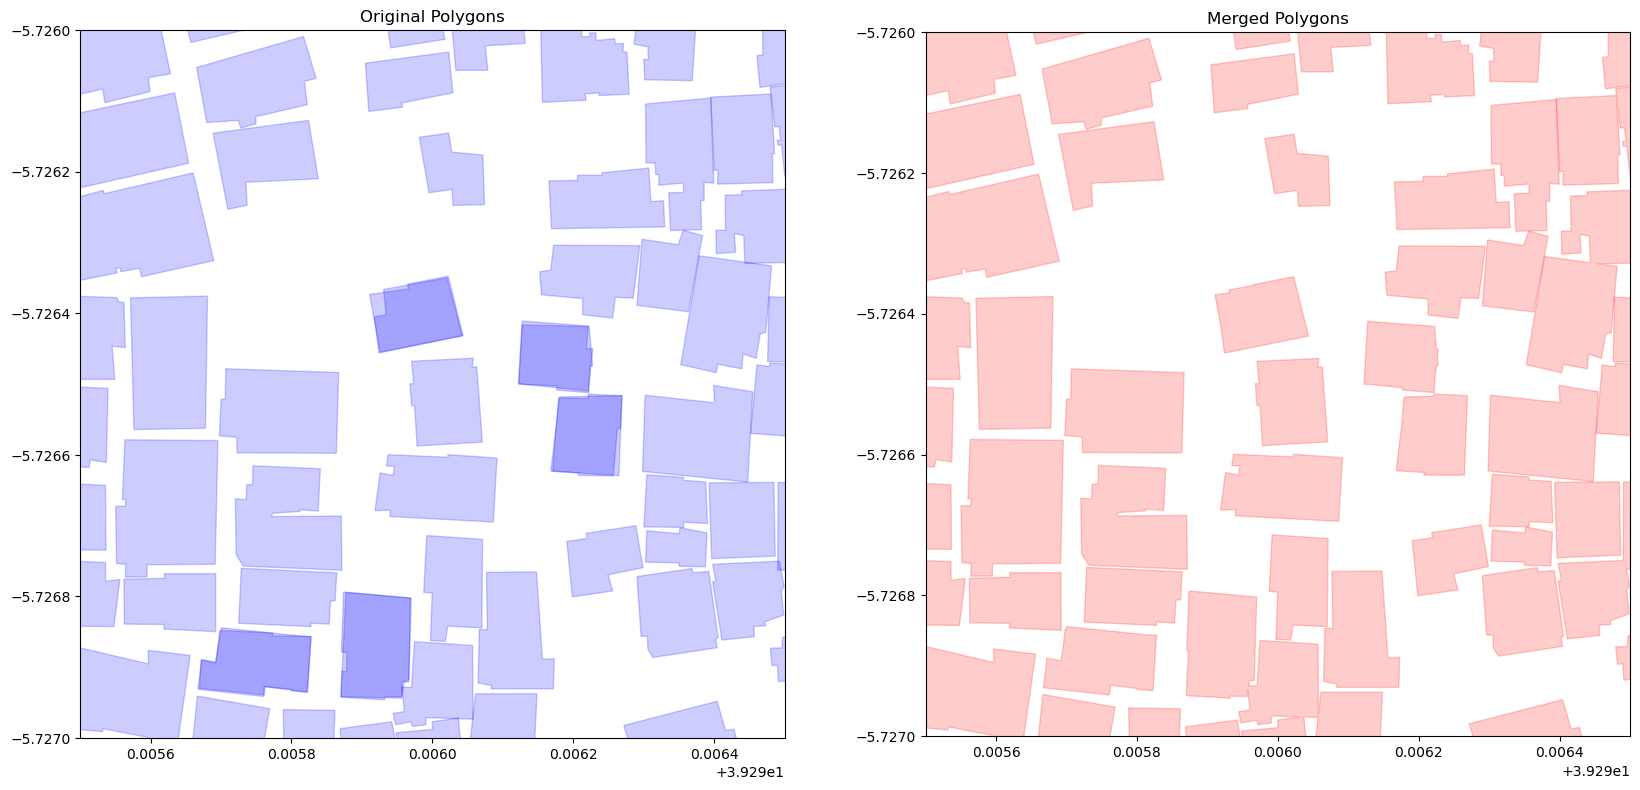

In [14]:
# Plot a cluster of the polygons before and after merging
merged_polygons = clean_invalid_geometries(labels_gdf['geometry'])

# Show two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the original polygons
labels_gdf['geometry'].plot(ax=ax1, color='blue', alpha=0.2, edgecolor='blue')
ax1.set_xlim(39.2955, 39.2965)
ax1.set_ylim(-5.727, -5.726)
ax1.set_title('Original Polygons')

# Plot the merged polygons
merged_polygons.plot(ax=ax2, color='red', alpha=0.2, edgecolor='red')
ax2.set_xlim(39.2955, 39.2965)
ax2.set_ylim(-5.727, -5.726)
ax2.set_title('Merged Polygons')

In [15]:
# Create a variable called all_polygons as a copy of merged_polygons
all_polygons = merged_polygons.copy()

# Get the same tile polygon as our tile image
tile_polygon = tiles_gdf.iloc[id]['geometry']
print('Polygon bounds: ', tile_polygon.bounds)

Polygon bounds:  (39.30084228515625, -5.729410754362032, 39.30152893066406, -5.728727538612972)


Using the [`from_bounds`](https://rasterio.readthedocs.io/en/stable/api/rasterio.transform.html#rasterio.transform.from_bounds) function from `rasterio.transform` we can get the affine transformation matrix for the tile. We can then use `rio-tiler` to read the tile image and the geoJSON labels file and crop the labels to the tile boundaries.

In [16]:
# Get affine transformation matrix for the tile using rasterio
transform_matrix = from_bounds(*tile_polygon.bounds, TILE_SIZE, TILE_SIZE)
transform_matrix

Affine(2.682209014892578e-06, 0.0, 39.30084228515625,
       0.0, -2.6688115197653905e-06, -5.728727538612972)

<AxesSubplot:>

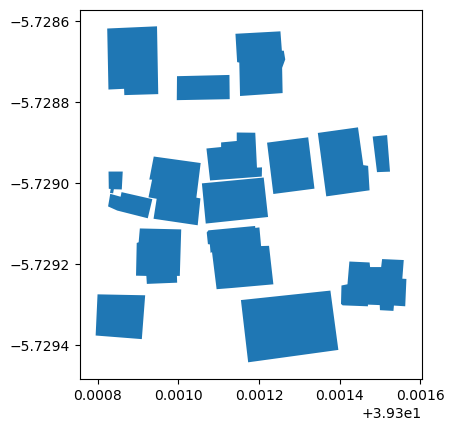

In [17]:
# Crop the merged polygons to the bounds of the tile
cropped_polygons = [polygon for polygon in all_polygons
                    if polygon.intersects(tile_polygon)]
cropped_polygons_gdf = gpd.GeoDataFrame(geometry=cropped_polygons, crs=4326)
cropped_polygons_gdf.plot()

## Create 3-channel RGB masks using solaris
Using the [`df_to_px_mask`](https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html) function in `solaris` we will create 3-channel Footprint, Boundary, Contact (FBC) RGB masks for each tile using the cropped building geometries. The mask channels generated are:
- Red channel: building footprints
- Green channel: building boundaries
- Blue channel: close contact points between buildings

Note that visually the green channel will appear yellow on the RGB mask display because the red and green channels overlap to create yellow.

In [18]:
# Burn the FCB 3 channel RGB mask using solaris
fcb_mask = sol.vector.mask.df_to_px_mask(df=cropped_polygons_gdf,
                                         channels=['footprint', 'boundary', 'contact'],
                                         affine_obj=transform_matrix,
                                         shape=(TILE_SIZE, TILE_SIZE),
                                         boundary_width=5,
                                         contact_spacing=5,
                                         boundary_type='inner',
                                         meters=True)

Text(0.5, 1.0, 'FCB Mask')

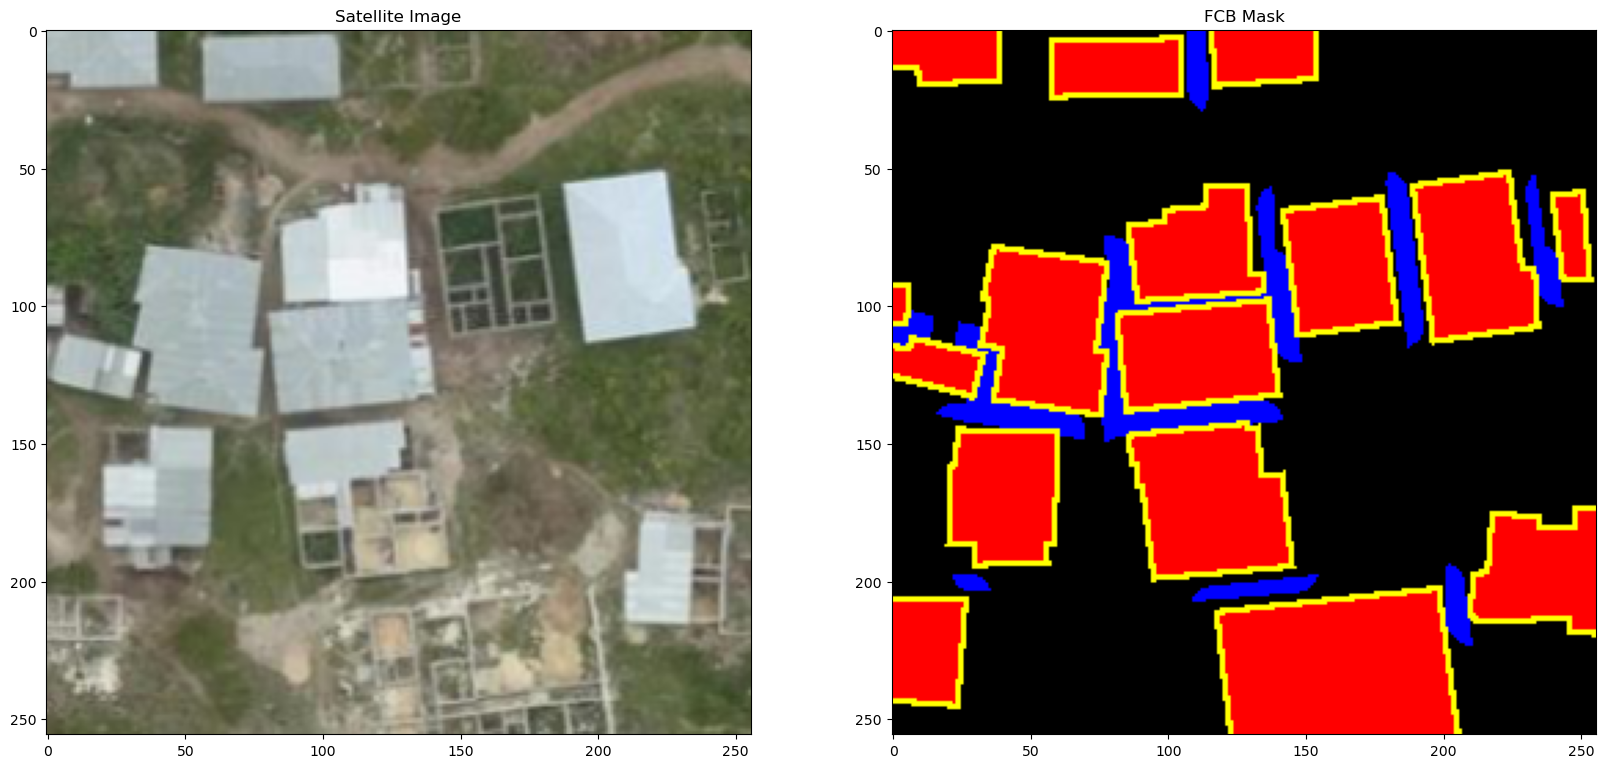

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(np.moveaxis(tile, 0, -1))
ax1.set_title('Satellite Image')
ax2.imshow(fcb_mask)
ax2.set_title('FCB Mask')

Text(0.5, 1.0, 'Contact')

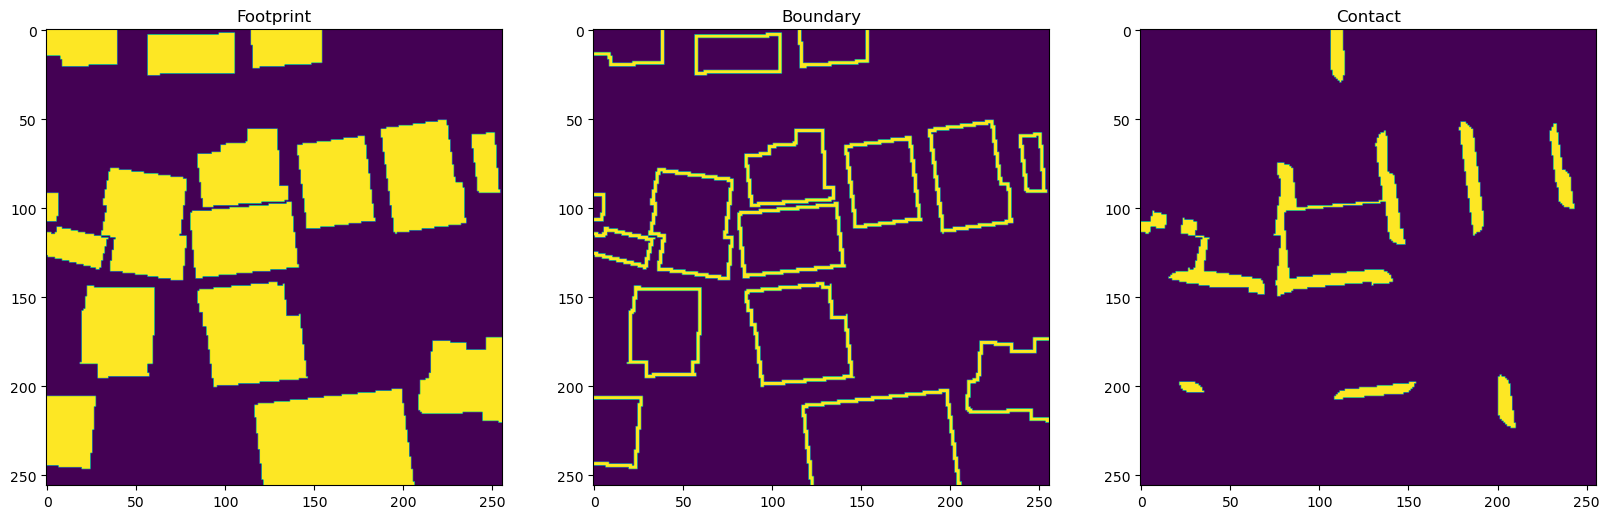

In [20]:
# Show each of the channels of the mask
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(fcb_mask[:, :, 0])
ax1.set_title('Footprint')

ax2.imshow(fcb_mask[:, :, 1])
ax2.set_title('Boundary')

ax3.imshow(fcb_mask[:, :, 2])
ax3.set_title('Contact')

# 2. Create training and validation datasets
Now that we have a working pipeline for a single tile, we will define functions to generate all the training and validation datasets.

We will loop through all of our `train` and `validation` tiles at a zoom level of 19 and save then as `png` files in the `images` or `masks` directories using the following naming convention:

`{IMAGE_PATH}/s{TILE_SIZE}_z{ZOOM_LEVEL}/{dataset}/{x}_{y}_{z}.png`

Where `x`, `y`, and `z` are the tile coordinates stored in each building's tuple in the `coordinates` column and `dataset` is either `train` or `validation`.

In [29]:
import skimage
from tqdm import tqdm
from typing import List, Tuple, Dict
import random

In [22]:
def save_tile_image(tif_file: str, image_path: str, dataset: str, coordinates: Tuple[int], tile_size: int, zoom_level: int):
    '''
    This function takes a tif file path and a tuple of coordinates and saves tile image
    to the images directory corresponding to the coordinates .

    Args:
        tif_file (str): A string path to the tif file.
        image_path (str): A string path to the root images directory.
        dataset (str): The dataset the tile belongs to (train or validation).
        coordinates (Tuple[int]): A tuple of coordinates in the format (x, y, z).
        tile_size (int): The size of the tile to save.
    '''
    # Destructure coordinates
    x, y, z = coordinates

    # Get the tile image and mask
    tile, mask = rt_main.tile(tif_file, x, y, z, tile_size)

    # Save the image
    skimage.io.imsave(image_path / f's{tile_size}_z{zoom_level}' / dataset
                      / f'{x}_{y}_{z}.png', np.moveaxis(tile, 0, -1), check_contrast=False)

In [23]:
def save_tile_mask(masks_path: str, dataset: str, coordinates: Tuple[int], tile_size: int, zoom_level: int, label_polygons: GeoSeries, tile_polygon: ShapelyPolygon):
    '''
    This function takes a tuple of coordinates, a geopandas series of building outline label polygons and a bounding tile polygon and and saves a 3 channel "FCB" RGB mask of the building labels within the tile.

    Args:
        masks_path (str): A string path to the root masks directory.
        dataset (str): The dataset the tile belongs to (train or validation).
        coordinates (Tuple[int]): A tuple of coordinates in the format (x, y, z).
        tile_size (int): The size of the tile to save.
        label_polygons (GeoSeries): A GeoSeries of building outline label polygons.
        tile_polygon (ShapelyPolygon): A Shapely Polygon of the tile bounds.
    '''
    # Destructure coordinates
    x, y, z = coordinates

    # Get affine transformation matrix for the tile using rasterio
    transform_matrix = from_bounds(*tile_polygon.bounds, tile_size, tile_size)

    # Crop the merged polygons to the bounds of the tile
    cropped_polygons = [polygon for polygon in label_polygons if polygon.intersects(tile_polygon)]
    cropped_polygons_gdf = gpd.GeoDataFrame(geometry=cropped_polygons, crs=4326)

    # Burn the FCB 3 channel RGB mask using solaris
    fcb_mask = sol.vector.mask.df_to_px_mask(df=cropped_polygons_gdf,
                                             channels=['footprint', 'boundary', 'contact'],
                                             affine_obj=transform_matrix,
                                             shape=(tile_size, tile_size),
                                             boundary_width=5,
                                             contact_spacing=5,
                                             boundary_type='inner',
                                             meters=True)

    # Save the mask
    skimage.io.imsave(masks_path / f's{tile_size}_z{zoom_level}' / dataset
                      / f'{x}_{y}_{z}_mask.png', fcb_mask, check_contrast=False)

In [24]:
def pre_process_tile(tif_file: str, image_path: str, masks_path: str, dataset: str, coordinates: Tuple[int], tile_size: int, zoom_level: int, label_polygons: GeoSeries, tile_polygon: ShapelyPolygon):
    '''
    This function will take a tif image, a tuple of coordinates, a geopandas series of label
    polygons and a bounding tile polygon and save a tile image and its corresponding mask to
    the images and masks directories by calling the save_image_tile and save_mask_tile functions.

    Args:
        tif_file (str): A string path to the tif file.
        image_path (str): A string path to the root images directory.
        masks_path (str): A string path to the root masks directory.
        dataset (str): The dataset the tile belongs to (train or validation).
        coordinates (Tuple[int]): A tuple of coordinates in the format (x, y, z).
        tile_size (int): The size of the tile to save.
        label_polygons (GeoSeries): A GeoSeries of building outline label polygons.
        tile_polygon (ShapelyPolygon): A Shapely Polygon of the tile bounds.
    '''

    # Save the tile image
    save_tile_image(tif_file, image_path, dataset, coordinates, tile_size, zoom_level)

    # Save the tile mask
    save_tile_mask(masks_path, dataset, coordinates, tile_size, zoom_level, label_polygons, tile_polygon)

In [25]:
# Check the number of tiles in the trainin and validation sets
print('Number of training tiles: ', len(tiles_gdf[tiles_gdf['dataset'] == 'train']))
print('Number of validation tiles: ', len(tiles_gdf[tiles_gdf['dataset'] == 'validation']))
tiles_gdf.head()

Number of training tiles:  814
Number of validation tiles:  592


,coordinates,title,geometry,dataset
0,"(319377, 270486, 19)","XYZ tile (319377, 270486, 19)","POLYGON ((39.29878 -5.71916, 39.29878 -5.71848...",train
1,"(319378, 270486, 19)","XYZ tile (319378, 270486, 19)","POLYGON ((39.29947 -5.71916, 39.29947 -5.71848...",train
2,"(319379, 270486, 19)","XYZ tile (319379, 270486, 19)","POLYGON ((39.30016 -5.71916, 39.30016 -5.71848...",train
3,"(319380, 270486, 19)","XYZ tile (319380, 270486, 19)","POLYGON ((39.30084 -5.71916, 39.30084 -5.71848...",train
4,"(319381, 270486, 19)","XYZ tile (319381, 270486, 19)","POLYGON ((39.30153 -5.71916, 39.30153 -5.71848...",train


In [28]:
# Loop through each tile in the tiles_gdf GeoDataFrame
for i, tile in tqdm(tiles_gdf.iterrows(), total=len(tiles_gdf)):
    pre_process_tile(TIF_INPUT_PATH, IMAGE_PATH, MASKS_PATH, tile['dataset'], tile['coordinates'], TILE_SIZE, ZOOM_LEVEL, all_polygons, tile['geometry'])

100%|██████████| 1406/1406 [04:04<00:00,  5.75it/s]


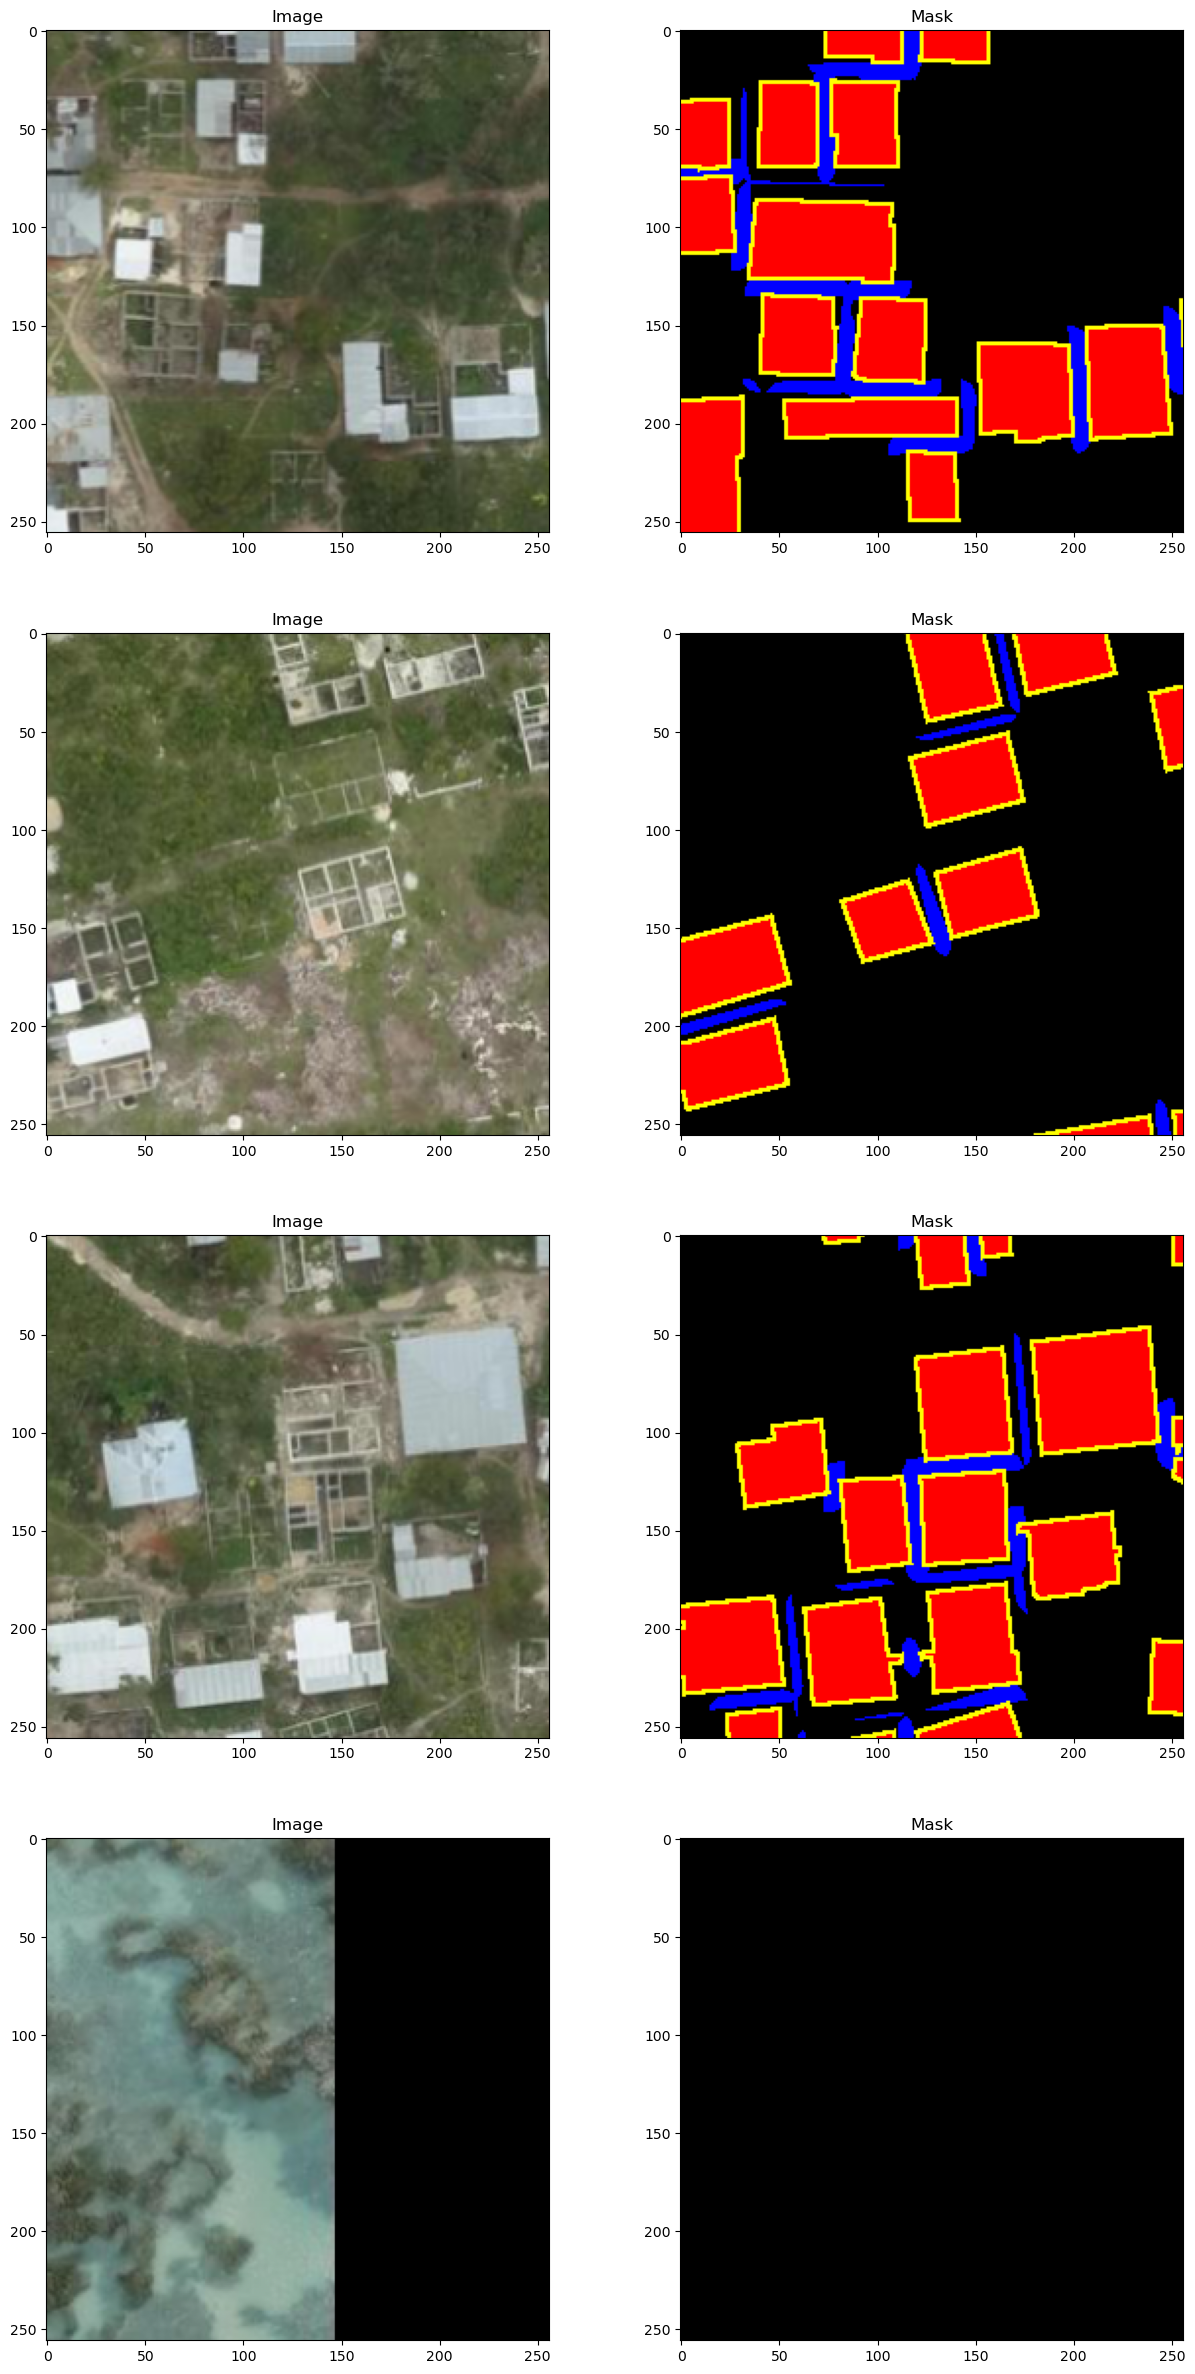

In [77]:
# Check 4 random training images and masks
random.seed(123)

fig, ax = plt.subplots(4, 2, figsize=(15, 30))
for i, (image, mask) in enumerate(random.sample(list(zip((IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'train').iterdir(), (MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'train').iterdir())), 4)):
    ax[i, 0].imshow(skimage.io.imread(image))
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(skimage.io.imread(mask))
    ax[i, 1].set_title('Mask')

plt.show()